In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install deeplake[enterprise]

In [ ]:
import deeplake
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import roc_auc_score, roc_curve
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, models

In [ ]:
train_ds = deeplake.load('hub://activeloop/nih-chest-xray-train')
test_ds = deeplake.load('hub://activeloop/nih-chest-xray-test')

train_ds = train_ds.query("select * sample by max_weight(contains(findings, 'Hernia'): 20, contains(findings, 'Pneumonia'): 8, contains(findings, 'Fibrosis'): 5, contains(findings, 'Edema'): 5, contains(findings, 'Emphysema'): 2, True: 1)")

Opening dataset in read-only mode as you don't have write permissions.


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/nih-chest-xray-train



/

hub://activeloop/nih-chest-xray-train loaded successfully.



/

Opening dataset in read-only mode as you don't have write permissions.


|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/nih-chest-xray-test



\

hub://activeloop/nih-chest-xray-test loaded successfully.



In [ ]:
train_ds, val_ds = train_ds.random_split([0.9, 0.1])

In [ ]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

77872
8652
25596


In [ ]:
image_transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.Grayscale(num_output_channels=1),
  transforms.RandomRotation(8),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.5], std=[0.5]),
])

def findings_transform(findings_list):
  multi_hot_encoded = [0] * (15)
  for index in findings_list:
    multi_hot_encoded[index] = 1

  return torch.Tensor(multi_hot_encoded)

batch_size = 16
num_workers = 2

train_loader = train_ds.dataloader()\
                 .transform({'images': image_transform, 'findings': findings_transform})\
                 .batch(batch_size)\
                 .shuffle(True)\
                 .pytorch(num_workers = num_workers, decode_method={'images': 'pil'})

val_loader = val_ds.dataloader()\
                 .transform({'images': image_transform, 'findings': findings_transform})\
                 .batch(batch_size)\
                 .shuffle(False)\
                 .pytorch(num_workers = num_workers, decode_method={'images': 'pil'})

test_loader = test_ds.dataloader()\
                 .transform({'images': image_transform, 'findings': findings_transform})\
                 .batch(batch_size)\
                 .shuffle(False)\
                 .pytorch(num_workers = num_workers, decode_method={'images': 'pil'})

In [ ]:
def save_results_to_file(result_file, train_loss, val_loss, micro_auc, macro_auc, per_class_auc_scores):
  with open(result_file, 'a') as f:
    f.write(f'{train_loss}, {val_loss}, {micro_auc}, {macro_auc},')

    for auc_score in per_class_auc_scores:
      f.write(f' {auc_score},')

    f.write('\n')

In [ ]:
def eval_one_epoch(model, criterion, data_loader, device):
  model.eval()
  all_preds = []
  all_labels = []
  running_val_loss = 0

  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      all_preds.append(outputs.sigmoid())
      all_labels.append(labels)

      loss = criterion(outputs, labels)
      running_val_loss += loss.item() * inputs.shape[0]

  val_average_loss = running_val_loss / len(data_loader.dataset)
  print(f'Validation phase completed. Average loss: {val_average_loss:.4f}')

  all_preds = torch.cat(all_preds, dim=0)
  all_labels = torch.cat(all_labels, dim=0)

  all_preds = all_preds.cpu().numpy()
  all_labels = all_labels.cpu().numpy()

  micro_auc_score = roc_auc_score(all_labels, all_preds, average='micro')
  print(f'Micro-averaged ROC AUC: {micro_auc_score}')

  macro_auc_score = roc_auc_score(all_labels, all_preds, average='macro')
  print(f'Macro-averaged ROC AUC: {macro_auc_score}')

  num_labels = all_labels.shape[1]
  plt.figure(figsize=(10, 8))

  per_class_auc_scores = []

  for label_index in range(num_labels):
    try:
      auc_score = roc_auc_score(all_labels[:, label_index], all_preds[:, label_index])
      per_class_auc_scores.append(auc_score)
      print(f'ROC AUC for label {label_index}: {auc_score}')

      fpr, tpr, _ = roc_curve(all_labels[:, label_index], all_preds[:, label_index])
      plt.plot(fpr, tpr, label=f'Label {label_index} (AUC = {auc_score:.2f})')
    except ValueError:
      print(f'ROC AUC for label {label_index}: Not Defined (No positive examples in labels)')
      per_class_auc_scores.append(None)

  plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curves')
  plt.legend(loc="lower right")
  plt.show()

  return val_average_loss, micro_auc_score, macro_auc_score, per_class_auc_scores

In [ ]:
def train_one_epoch(model, optimizer, criterion, data_loader, val_data_loader, device):
  model.train()

  running_train_loss = 0

  for i, data in enumerate(data_loader):
    inputs = data['images']
    labels = data['findings']

    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    outputs = model(inputs)

    loss = criterion(outputs, labels)
    running_train_loss += loss.item() * inputs.shape[0]

    loss.backward()
    optimizer.step()

    if i % 1000 == 999:
      print(f'Batch: {i + 1}/{len(data_loader)}')

  train_average_loss = running_train_loss / len(data_loader.dataset)
  print(f'Training phase completed. Average loss: {train_average_loss:.4f}')

  val_results = eval_one_epoch(model, criterion, val_data_loader, device)
  val_average_loss, micro_auc_score, macro_auc_score, avg_auc_for_all_classes = val_results

  return train_average_loss, val_average_loss, micro_auc_score, macro_auc_score, avg_auc_for_all_classes

In [ ]:
def class_averaged_binary_cross_entropy(preds, targets):
  num_classes = 15
  loss = 0

  for c in range(num_classes):
    loss_c = F.binary_cross_entropy(preds[:, c], targets[:, c])
    loss += loss_c

  loss /= num_classes

  return loss

In [ ]:
def save_model(result_file_model, model, model_name, epoch):
  model_save_path = f'{result_file_model}/{model_name}_checkpoint_epoch_{epoch}.pt'
  torch.save(model.state_dict(), model_save_path)
  print(f'Model saved at {model_save_path}')

In [ ]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

num_ftrs = model.fc.in_features
num_labels = 15

model.fc = nn.Sequential(
  nn.Linear(2048, 1000),
  nn.ReLU(),
  nn.Linear(1000, num_labels),
  nn.Softmax(dim=1)
)

for name, param in model.named_parameters():
  if ('layer3' in name) or ('layer4' in name) or ('fc' in name):
    param.requires_grad = True
  else:
    param.requires_grad = False

for param in model.conv1.parameters():
  param.requires_grad = True

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Running on {device}')

criterion = class_averaged_binary_cross_entropy
optimizer = optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = 0.001, betas=(0.9, 0.999))

model = model.to(device)

Running on cuda


------------------ Training Epoch 1 ------------------


Please wait, filling up the shuffle buffer with samples.: 100%|█████████▉| 2.00G/2.00G [00:21<00:00, 101MB/s]


Shuffle buffer filling is complete.
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.2330
Validation phase completed. Average loss: 0.2447
Micro-averaged ROC AUC: 0.8202814010775228
Macro-averaged ROC AUC: 0.6846785339853104
ROC AUC for label 0: 0.7205241789805392
ROC AUC for label 1: 0.6959989637282555
ROC AUC for label 2: 0.6887102057156375
ROC AUC for label 3: 0.6131236101139474
ROC AUC for label 4: 0.6193820424312914
ROC AUC for label 5: 0.7344214724159214
ROC AUC for label 6: 0.5592260091018515
ROC AUC for label 7: 0.7766301082615713
ROC AUC for label 8: 0.6067309773127421
ROC AUC for label 9: 0.6886323363582667
ROC AUC for label 10: 0.6962268102419442
ROC AUC for label 11: 0.7348982151388984
ROC AUC for label 12: 0.6251465088199781
ROC AUC for label 13: 0.6311340992969511
ROC AUC for label 14: 0.8793924718618583


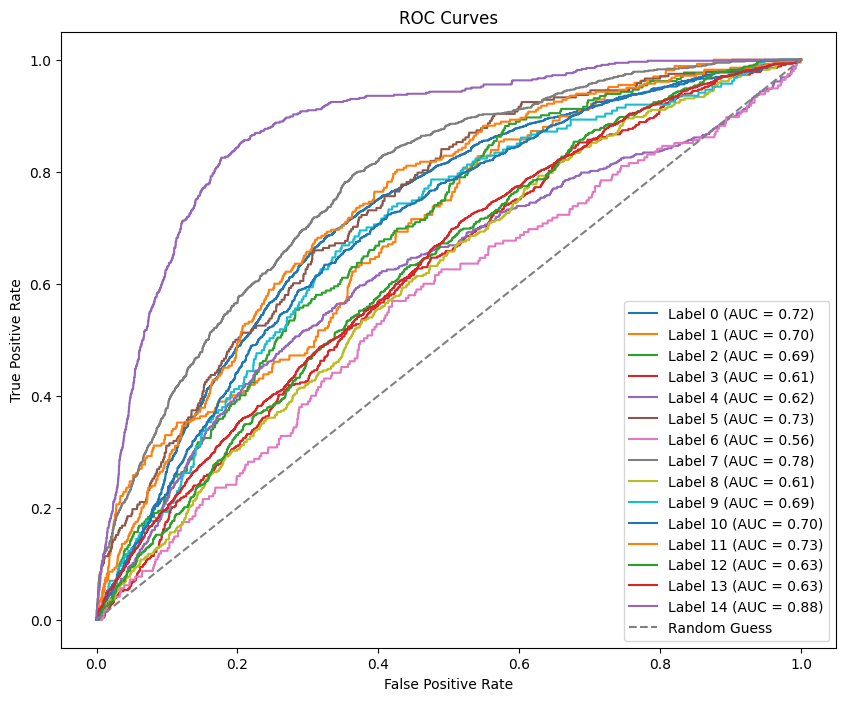

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_BCE_Avg_Loss_Balanced_ResNet50_checkpoint_epoch_1.pt
------------------ Training Epoch 2 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.2165
Validation phase completed. Average loss: 0.2583
Micro-averaged ROC AUC: 0.8192537691572642
Macro-averaged ROC AUC: 0.7002474873990316
ROC AUC for label 0: 0.7236338648684966
ROC AUC for label 1: 0.7518986776368538
ROC AUC for label 2: 0.7177888071040588
ROC AUC for label 3: 0.6130135506818541
ROC AUC for label 4: 0.5978834841078995
ROC AUC for label 5: 0.7154647216623753
ROC AUC for label 6: 0.6298699605546005
ROC AUC for label 7: 0.8213779702982303
ROC AUC for label 8: 0.6520556486569408
ROC AUC for label 9: 0.6879488046091013
ROC AUC for label 10: 0.7050014677251297
ROC AUC for label 11: 0.7330376339499011
ROC AUC for label 12: 0.6268658946663481
ROC AUC for label 13: 0.6389242280976861
ROC AUC fo

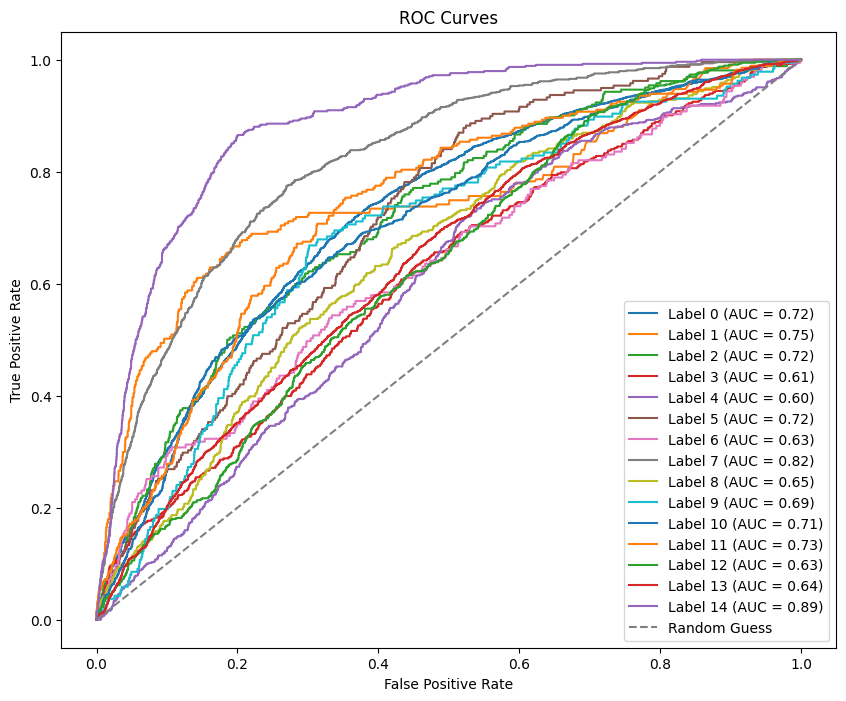

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_BCE_Avg_Loss_Balanced_ResNet50_checkpoint_epoch_2.pt
------------------ Training Epoch 3 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.2049
Validation phase completed. Average loss: 0.2630
Micro-averaged ROC AUC: 0.8161129779765897
Macro-averaged ROC AUC: 0.7091804110000253
ROC AUC for label 0: 0.7256782900254615
ROC AUC for label 1: 0.7595635151945578
ROC AUC for label 2: 0.735022382152508
ROC AUC for label 3: 0.5938589481844896
ROC AUC for label 4: 0.5946607478767525
ROC AUC for label 5: 0.7511750124342582
ROC AUC for label 6: 0.7012115589270609
ROC AUC for label 7: 0.8121611498746777
ROC AUC for label 8: 0.7000138697500442
ROC AUC for label 9: 0.6991042070052529
ROC AUC for label 10: 0.7028986142787795
ROC AUC for label 11: 0.7273799569995222
ROC AUC for label 12: 0.631563120678767
ROC AUC for label 13: 0.6435045720431987
ROC AUC for 

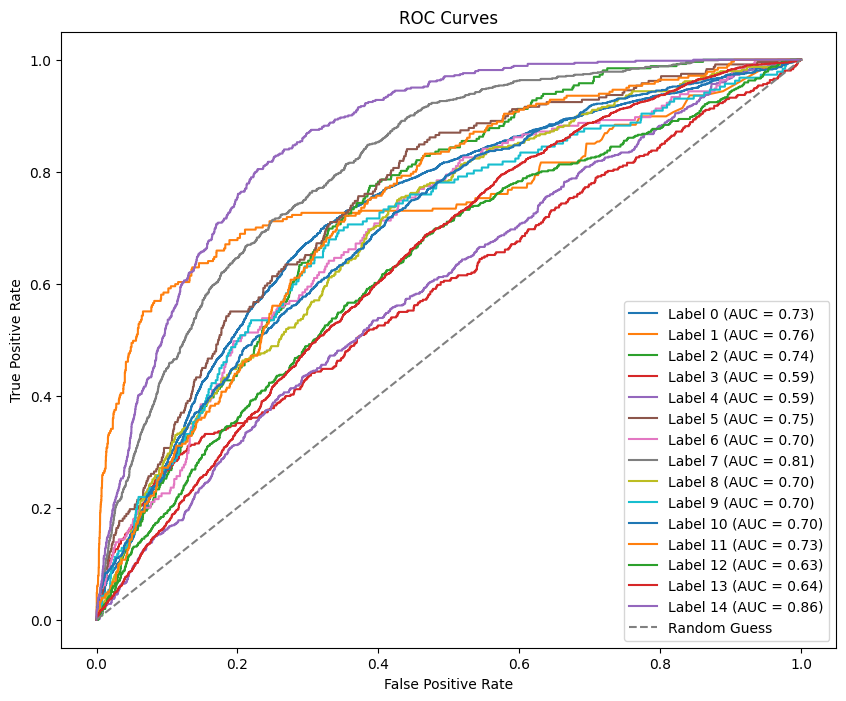

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_BCE_Avg_Loss_Balanced_ResNet50_checkpoint_epoch_3.pt
------------------ Training Epoch 4 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1920
Validation phase completed. Average loss: 0.2608
Micro-averaged ROC AUC: 0.8161642839459302
Macro-averaged ROC AUC: 0.7241230161956033
ROC AUC for label 0: 0.725131404150271
ROC AUC for label 1: 0.7573880145346044
ROC AUC for label 2: 0.7479041752722707
ROC AUC for label 3: 0.6192139082207195
ROC AUC for label 4: 0.6479247149369664
ROC AUC for label 5: 0.7336062544818259
ROC AUC for label 6: 0.8061348056381756
ROC AUC for label 7: 0.8264889863964481
ROC AUC for label 8: 0.6878902221667708
ROC AUC for label 9: 0.7297734300722384
ROC AUC for label 10: 0.6901828257954452
ROC AUC for label 11: 0.7182067350351511
ROC AUC for label 12: 0.6554501935454317
ROC AUC for label 13: 0.6671735411905435
ROC AUC for

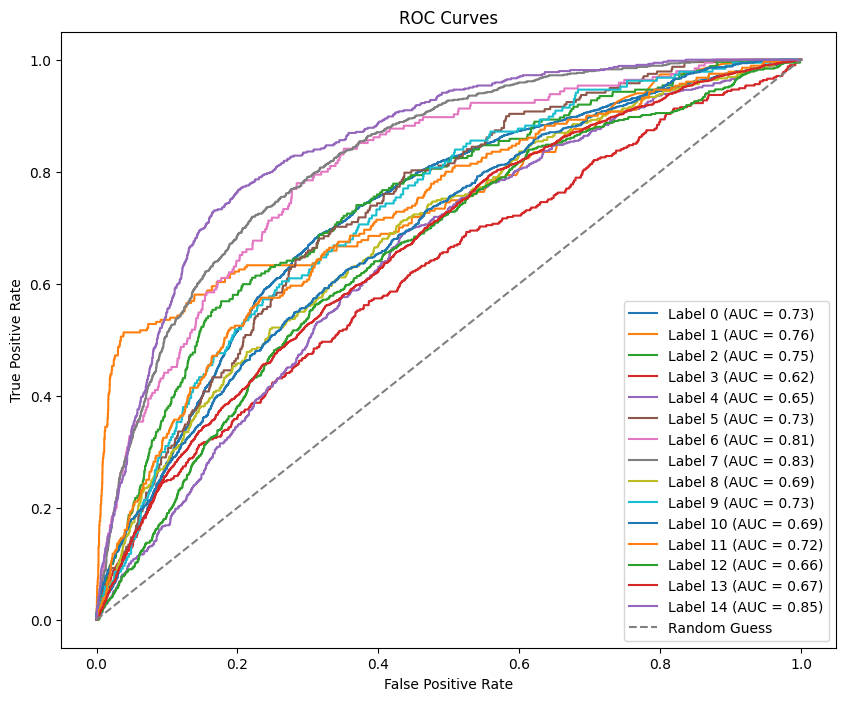

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_BCE_Avg_Loss_Balanced_ResNet50_checkpoint_epoch_4.pt
------------------ Training Epoch 5 ------------------
Batch: 1000/4867
Batch: 2000/4867
Batch: 3000/4867
Batch: 4000/4867
Training phase completed. Average loss: 0.1798
Validation phase completed. Average loss: 0.2737
Micro-averaged ROC AUC: 0.811186664803377
Macro-averaged ROC AUC: 0.7247159396584896
ROC AUC for label 0: 0.7255285200045167
ROC AUC for label 1: 0.7885813573819845
ROC AUC for label 2: 0.74834772402624
ROC AUC for label 3: 0.6463523012707235
ROC AUC for label 4: 0.6041860043306395
ROC AUC for label 5: 0.7188042438273146
ROC AUC for label 6: 0.808031277382111
ROC AUC for label 7: 0.8247003109323883
ROC AUC for label 8: 0.6799771892146595
ROC AUC for label 9: 0.6970081272051323
ROC AUC for label 10: 0.7075391239441714
ROC AUC for label 11: 0.72648283393625
ROC AUC for label 12: 0.6772961228743541
ROC AUC for label 13: 0.6699166938678885
ROC AUC for labe

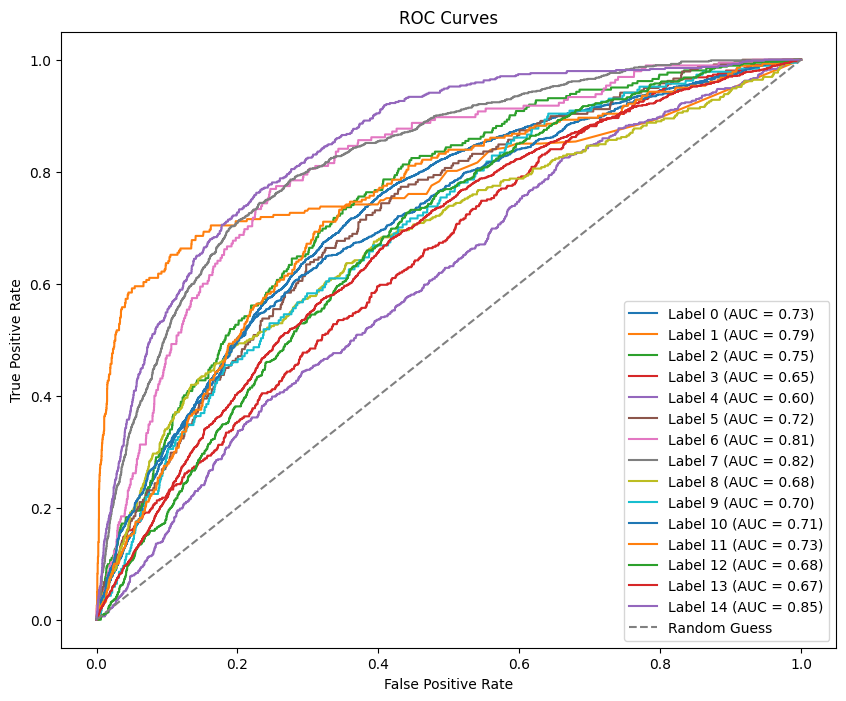

Model saved at /content/drive/MyDrive/SSN_Projekt/Saved_Models//SSN_BCE_Avg_Loss_Balanced_ResNet50_checkpoint_epoch_5.pt


In [ ]:
num_epochs = 5
model_name = "SSN_BCE_Avg_Loss_Balanced_ResNet50"
result_file_model = "/content/drive/MyDrive/SSN_Projekt/Saved_Models/"
result_file_metrics = "/content/drive/MyDrive/SSN_Projekt/Metrics/SSN_BCE_Avg_Loss_Balanced_ResNet50.txt"

for epoch in range(num_epochs):
  print(f"------------------ Training Epoch {epoch + 1} ------------------")
  train_avg_loss, val_avg_loss, micro_auc, macro_auc, per_class_auc_scores = train_one_epoch(model, optimizer, criterion, train_loader, val_loader, device)
  save_results_to_file(result_file_metrics, train_avg_loss, val_avg_loss, micro_auc, macro_auc, per_class_auc_scores)

  save_model(result_file_model, model, model_name, epoch + 1)